# Forecasting Annual Water Demand

In [164]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [158]:
# Load the data
data = pd.read_csv('water-consumption-in-the-new-york-city.csv')

In [159]:
data.head()

,Year,New York City Population,NYC Consumption(Million gallons per day),Per Capita(Gallons per person per day)
0,1979,7102100.0,1512.0,213
1,1980,7071639.0,1506.0,213
2,1981,7089241.0,1309.0,185
3,1982,7109105.0,1382.0,194
4,1983,7181224.0,1424.0,198


### Check Stationarity (Augmented Dickey-Fuller)

In [165]:
def check_stationarity(time_series):
    result = adfuller(time_series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [166]:
check_stationarity(data['Year'])

ADF Statistic: -0.039024
p-value: 0.955183
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


The results of Augmented Dickey-Fuller (ADF) test suggest that the time series data is likely non-stationary. Here's how to interpret these results:

* ADF Statistic: The value of -0.039024 is higher than all the critical values at the 1%, 5%, and 10% levels. In general, for a time series to be considered stationary, the ADF statistic should be a large negative number, well below the critical values.

* p-value: At 0.955183, it's much higher than the common threshold of 0.05. A high p-value indicates that the null hypothesis of the ADF test (which states that the time series has a unit root and is non-stationary) cannot be rejected.

* Critical Values: These are the threshold values for the ADF statistic at different confidence levels. The ADF statistic does not exceed (in absolute value) any of these critical values.

Based on these results, we would not reject the null hypothesis and would conclude that the time series data is non-stationary. This means we may need to transform the data to make it stationary before applying ARIMA or other time series forecasting models.

### Stationarity

To achieve stationarity in time series data, we can apply a few common techniques.

* Differencing: This involves subtracting the previous observation from the current observation. Sometimes, multiple rounds of differencing may be necessary.

* Transformation: For example, applying a logarithmic transformation can help stabilize the variance of a series.

* Decomposition: You can decompose the time series into trend, seasonality, and residuals and then model the residuals, which are often more stationary.

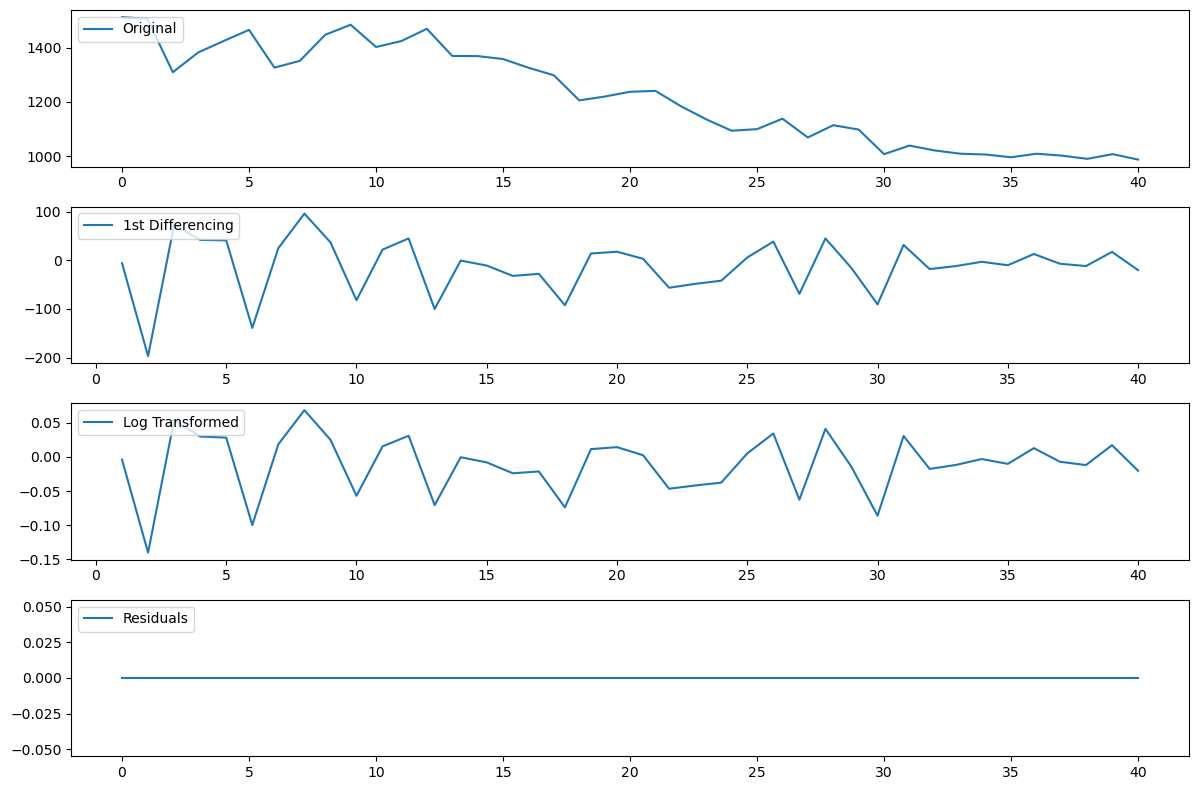

In [170]:
# Method 1: Differencing
data_diff = data['NYC Consumption(Million gallons per day)'].diff().dropna()

# Method 2: Log Transformation
data_log = np.log(data['NYC Consumption(Million gallons per day)'])
data_log_diff = data_log.diff().dropna()

# Method 3: Decomposition
decomposition = seasonal_decompose(data['NYC Consumption(Million gallons per day)'], model='additive', period=1)
residual = decomposition.resid.dropna()

# Plotting the transformed data
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(data['NYC Consumption(Million gallons per day)'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(data_diff, label='1st Differencing')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(data_log_diff, label='Log Transformed')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


# ARIMA

In [136]:
data.set_index('Year', inplace=True)

In [137]:
# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None
best_model = None

# Grid Search
for param in pdq:
    try:
        mod = sm.tsa.ARIMA(data['NYC Consumption(Million gallons per day)'], order=param)
        results = mod.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except Exception as e:
        continue

if best_model is not None:
    print('Best ARIMA{} - AIC:{}'.format(best_pdq, best_aic))
    print(best_model.summary())
else:
    print("No suitable model found")

/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

Best ARIMA(2, 2, 1) - AIC:429.37465100499924
                                          SARIMAX Results                                           
Dep. Variable:     NYC Consumption(Million gallons per day)   No. Observations:                   41
Model:                                       ARIMA(2, 2, 1)   Log Likelihood                -210.687
Date:                                      Fri, 17 Nov 2023   AIC                            429.375
Time:                                              15:43:11   BIC                            436.029
Sample:                                                   0   HQIC                           431.762
                                                       - 41                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

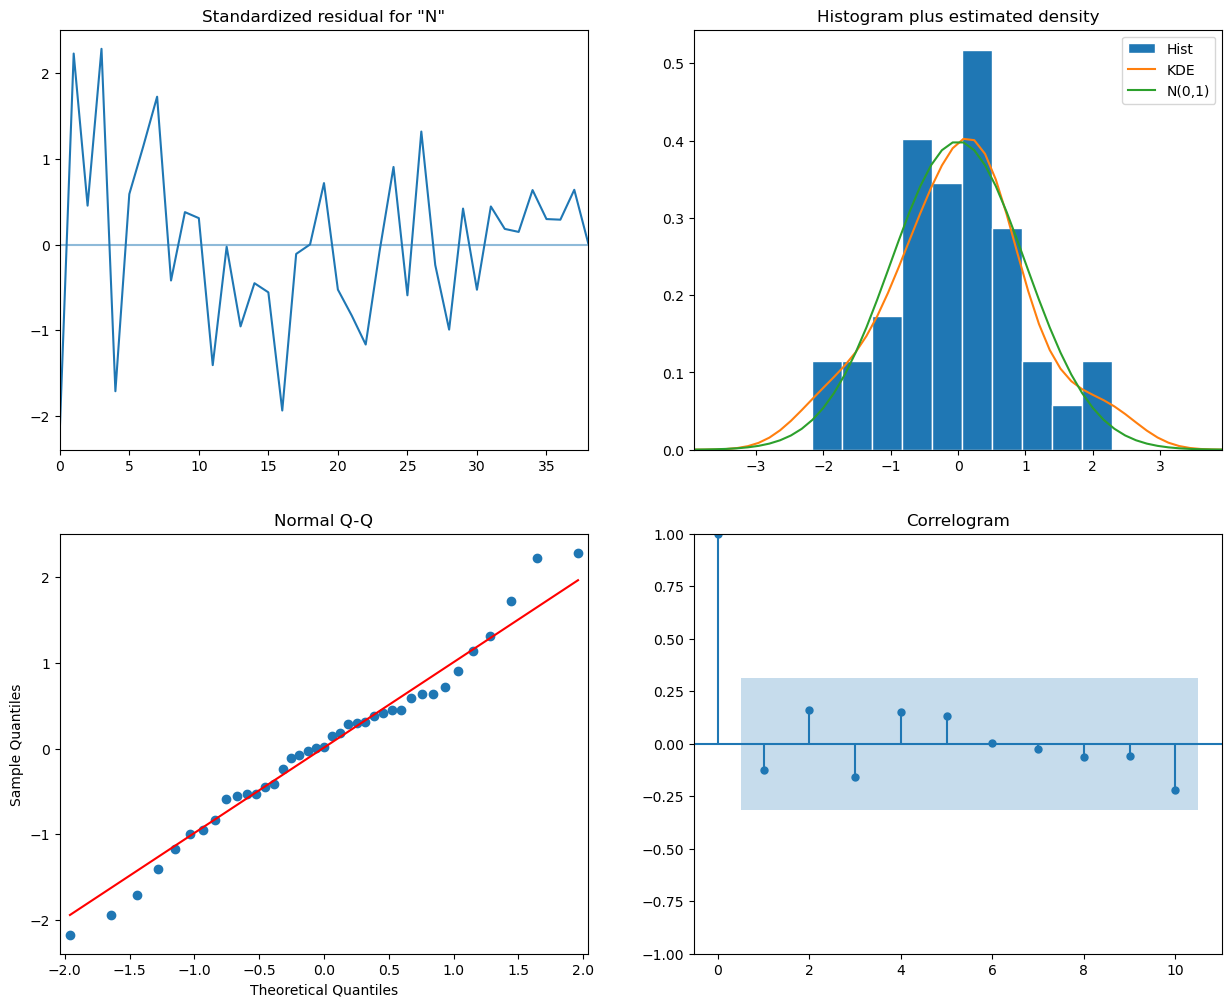

In [138]:
# Model diagnostics
model_diagnostics = best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In the offical website they added the years 2020 and 2021 (https://www.nyc.gov/site/dep/water/history-of-drought-water-consumption.page)

/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


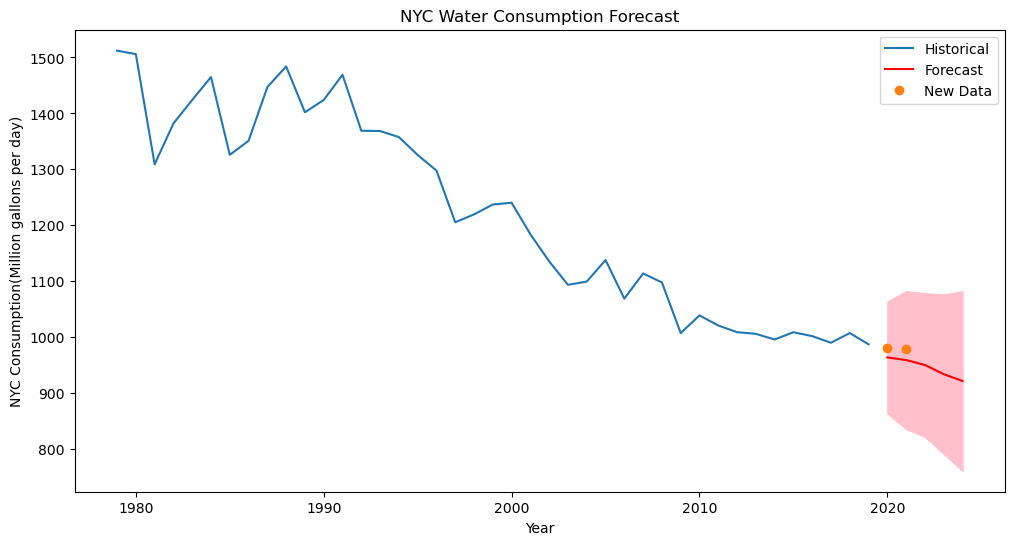

In [139]:
# Forecasting the next 5 years
forecast = best_model.get_forecast(steps=5)
forecast_index = range(data.index[-1] + 1, data.index[-1] + 6) # Assuming the index is the year

# Confidence intervals for the forecasts
forecast_ci = forecast.conf_int()

# Plotting the forecast alongside historical data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['NYC Consumption(Million gallons per day)'], label='Historical')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='pink')

plt.plot([2020,2021],[981.0, 979.0], marker='o', ls='none', label='New Data')

plt.title("NYC Water Consumption Forecast")
plt.xlabel("Year")
plt.ylabel("NYC Consumption(Million gallons per day)")
plt.legend()
plt.show()


In [148]:
# Split the data into training and test sets
train_data = data.iloc[:-5]  # Using all data except the last 3 years for training
test_data = data.iloc[-5:]   # Using the last 3 years for testing

# Fit the ARIMA model
model = ARIMA(train_data['NYC Consumption(Million gallons per day)'], order=(2,2,1))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=5)

# Comparing with Test Data
actual = test_data['NYC Consumption(Million gallons per day)']
predicted = forecast

/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/mac/Downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/ts

### Actual vs Predicted

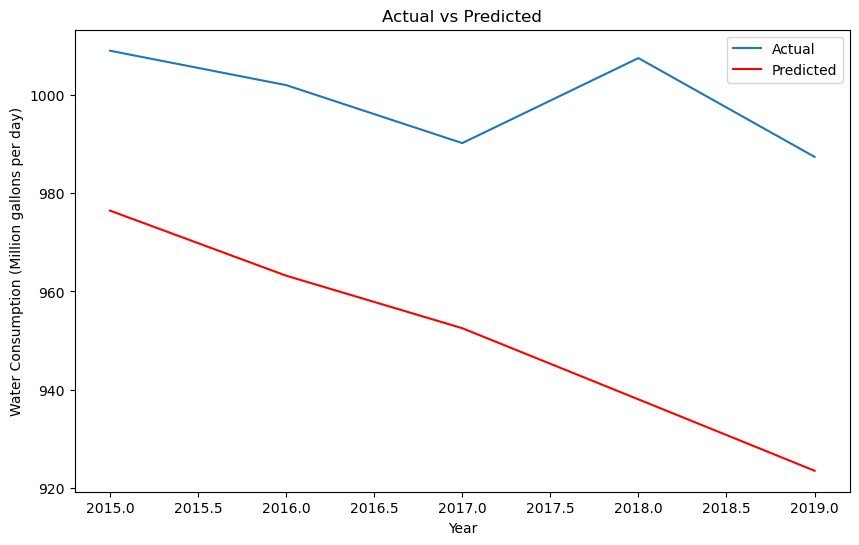

In [149]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(actual.index, actual, label='Actual')
plt.plot(actual.index, predicted, label='Predicted', color='red')
plt.title("Actual vs Predicted")
plt.xlabel("Year")
plt.ylabel("Water Consumption (Million gallons per day)")
plt.legend()
plt.show()

### Residual Analysis

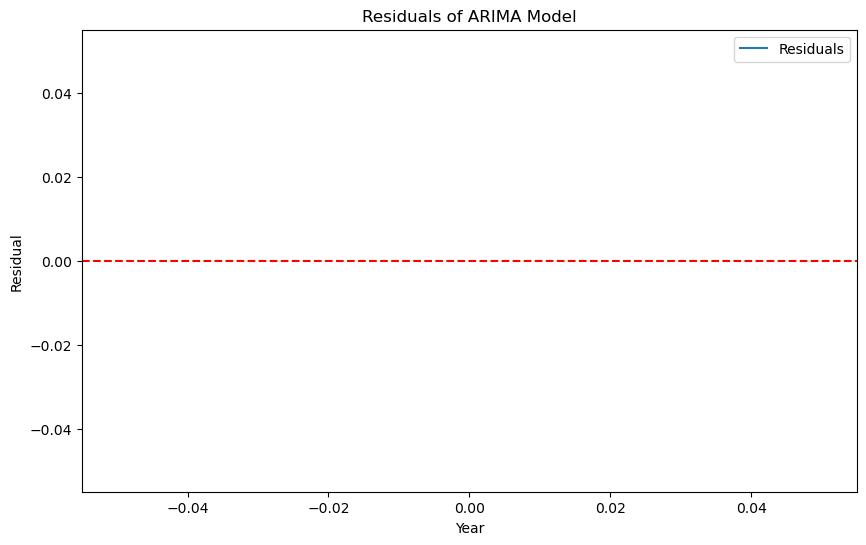

In [150]:
# Residual Analysis
residuals = actual - predicted
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.title("Residuals of ARIMA Model")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

### Error Metrics

In [151]:
# Error Metrics
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 2577.547700111769
Root Mean Squared Error: 50.76955485437871
Mean Absolute Error: 48.46818797099074


* The RMSE and MAE are quite close in value, suggesting that there are no major outliers significantly influencing the error. However, the magnitude of these errors (around 50 million gallons per day).
* Additionally, examining the residuals plot is crucial. Ideally, the residuals should be randomly scattered around zero.

For better insights, let's compare these error metrics with the range and distribution of the actual data. It will help understand the proportion of error in relation to the data's scale.

Data Descriptive Statistics:
 count      41.000000
mean     1222.658537
std       177.967116
min       987.400000
25%      1039.000000
50%      1219.500000
75%      1369.000000
max      1512.000000
Name: NYC Consumption(Million gallons per day), dtype: float64


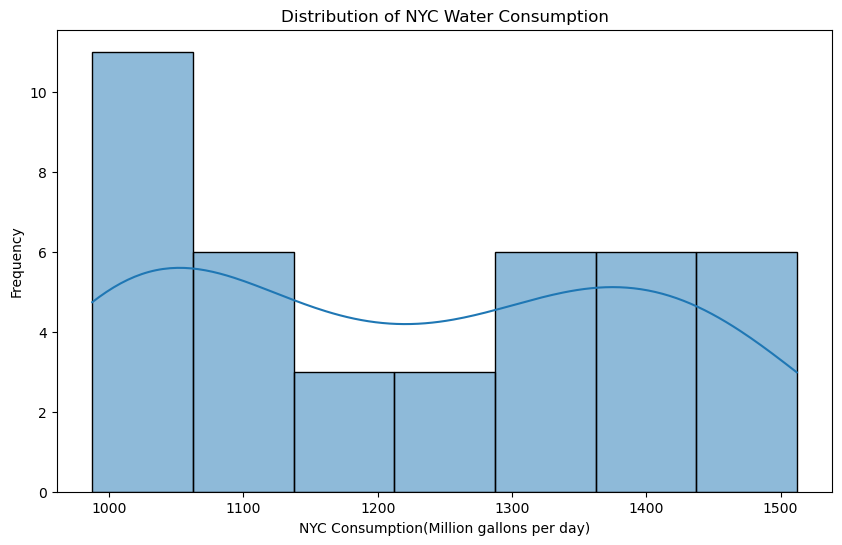


Error Metrics:
Mean Squared Error (MSE): 2577.5477
Root Mean Squared Error (RMSE): 50.7696
Mean Absolute Error (MAE): 48.4682

Comparison:
Mean of Actual Data: 1222.658536585366
Standard Deviation of Actual Data: 177.9671163103029


In [154]:
# Step 1: Descriptive Statistics
data_stats = data['NYC Consumption(Million gallons per day)'].describe()
print("Data Descriptive Statistics:\n", data_stats)

# Step 2: Visualize the Data Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['NYC Consumption(Million gallons per day)'], kde=True)
plt.title('Distribution of NYC Water Consumption')
plt.xlabel('NYC Consumption(Million gallons per day)')
plt.ylabel('Frequency')
plt.show()

# Step 3: Compare Error Metrics with Data Statistics
print("\nError Metrics:")
print("Mean Squared Error (MSE):", 2577.5477)
print("Root Mean Squared Error (RMSE):", 50.7696)
print("Mean Absolute Error (MAE):", 48.4682)

# Additional comparison
print("\nComparison:")
print("Mean of Actual Data:", data_stats['mean'])
print("Standard Deviation of Actual Data:", data_stats['std'])
